The analysis in this notebook was conducted using Wikipedia dump (Polish language version) dated 01.04.2018 (this version isn't available online anymore, but you can download the latest dumps from https://dumps.wikimedia.org/plwiki/ ). The files prepared originally in XML format were parsed to JSON files using https://github.com/attardi/wikiextractor scripts in order to process them easier in Python.

From all the articles written in Polish only those containing biographies were chosen (using the filtering condition that the phrase "ur." or "(ur." (shortcut for "born" in Polish) must be present in the first 500 characters of an article). After applying that condition almost 270k articles were selected.

In [1]:
from WikipediaUtils import PrepareWikipedia # custom class to pre-process data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression # to check Zipf law
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob as tb # for alternative tf-idf implementation

# stemming for Polish:
from pyMorfologik import Morfologik
from pyMorfologik.parsing import ListParser #, DictParser

import os
import sys
import json
import operator
from collections import Counter
import pickle

The most common and at the same time the least useful terms are the so called ___stop words___. These are the words which in conjunction with other words form sentences or phrases, such as "and", "but", "which" etc. This kind of words should be removed from data as they introduce noise and are irrelevant from the perspective of interesting patterns in data. Another benefit of removing such words is less memory usage.

The next step in the analysis was to lowercase all words and use a transformation called ___lemmatization___. Lemmatization is a process of creating a lemma i.e. the canonical, dicionary form of a word. For example as a result of lemmatizing the word "went" we would get word "go", or "the best"$\rightarrow$"good", "mice"$\rightarrow$"mouse". Other useful transformation is ___stemming___, which aims at finding a root form of a word. The result of stemming may not be a valid word which could be found in a dictionary.

In order to stem articles written in Polish I used PyMorfologik package which is Polish morphological analyzer, which uses data from Narodowy Korpus Języka Polskiego (NKJP).




In [2]:
from WikipediaUtils import PrepareWikipedia
wiki_obj = PrepareWikipedia(path="/home/ec2-user", word=["ur.", "(ur."])

biogr = wiki_obj.extract_articles()
biogr = wiki_obj.remove_stop_words(biogr)
biogr = wiki_obj.stem_articles(biogr)
#final = wiki_obj.extract_text(biogr)

# Zipf law verification
Zipf law describes an empirically observed rule which in case of text analysis relates to the fact, that for a given set of words occuring within a corpus of documents, the frequency of a given word is inversely proportional to its rank in a frequency table calculated for the entire corpus. In other words, the most frequent word in a corpus should be twice as frequent as the second most frequent, three times as frequent as the third most frequent etc.

$frequency_{word} = \frac{const.}{rank_{word}}$

The differences between theoretical and empirical distribution were verified for the analysed articles. The linear model was fitted for words with ranks ranging from 10 to 1000 in a frequency table (both explanatory and dependent variables were log-transformed). The plot shows that Zipf law doesn't apply in case of this corpus - the most frequent words occur less often than it would result from theoretical distribution.

In [3]:
# count the number of occurences for all words
all_words = [x for y in wiki_obj.extract_text(biogr) for x in y.split(" ")]
word_counts = Counter(all_words)
# sort the result
word_counts_sorted = sorted(word_counts.items(), key=operator.itemgetter(1), reverse = True)

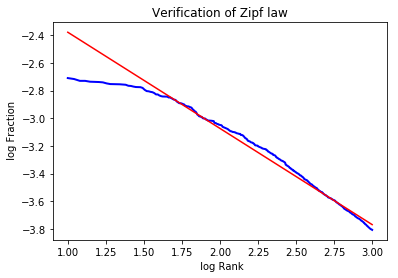

In [4]:
freq_df = pd.DataFrame(word_counts_sorted, columns = ['word', 'n'])
freq_df['fraction'] = freq_df['n'] / sum(freq_df['n'])
freq_df['rank'] = range(1,(freq_df.shape[0]+1))

freq_df_top = freq_df.loc[(freq_df['rank']<=1000) & (freq_df['rank']>=10), :]

# fitting linear regression
lin_reg = LinearRegression()
lin_reg.fit(X=np.log10(freq_df_top[['rank']]), y=np.log10(freq_df_top['fraction']))
slope = np.float(lin_reg.coef_)
intercept = np.float(lin_reg.intercept_)

fig, ax = plt.subplots(1)
# empirical:
ax.plot(np.log10(freq_df_top['rank']), np.log10(freq_df_top['fraction']), color='blue', lw=2)
# theoretical:
ax.plot(np.log10(freq_df_top['rank']), slope*np.log10(freq_df_top['rank'])+intercept, color='red')
ax.set(xlabel=" log Rank", ylabel=" log Fraction", title="Verification of Zipf law")
plt.show()

# tf-idf calculation
It is also useful to check the so called ___tf-idf___ (_term frequency - inverse document frequency_) statistics. It shows the weight, importance of a word in a particuar document taking into account the frequency of that word in a set of analysed documents.
The statistics for a word $i$ in a document $d$ id calculated as a product of a frequency of that word in a document (term frequency part) and the logarithm of inverse frequency of that word in a corpus of documents:

$tf(i, d) = \frac{\text{number of times words i occurs in document d}}{\text{number of words in document d}}$

$idf(i) = ln(\frac{\text{number of documents in a corpus}}{\text{number of documents containing word i}})$

In other words the tf-idf statistics is:
* the largest when word $i$ occurs many times in a relatively small set of documents (including document $d$)
* average when the word occurs rarely in document $d$ or appears in many documents in a corpus
* the lowest when the word occurs in nearly all documents (_stop-words_ belong to this group)

The following analysis was conducted for the top 100 (in terms of articles' length) biographies.

In [5]:
art_lengths = []
for indeks, art in enumerate(biogr):
    krotka = (art['title'],len(art['text']))
    art_lengths.append(krotka)
    
longest_art = pd.DataFrame(art_lengths, columns = ['title','length']).sort_values('length', ascending=False)

titles = longest_art['title'].iloc[:100].tolist()

tf_idf_art = []
for art in biogr:
    if art['title'] in titles:
        tf_idf_art.append(art)

tf_idf_art = sorted(tf_idf_art, key=lambda k: len(k['text']), reverse=True)

In [6]:
# creating blobs of text
doc_list = [tb(tf_idf_art[i]['text']) for i in range(len(tf_idf_art))]

# creating counts for idf part
unique_words = [x.words for x in doc_list]
unique_words = [x for y in unique_words for x in y]
idf_dict = dict(Counter(unique_words))

# defining functions to calculate tf-idf statistics
def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def idf(word, doc_list):
    return np.log(len(doc_list) / (1 + idf_dict.get(word, 0)))

def tfidf(word, blob, doc_list):
    return tf(word, blob) * idf(word, doc_list)

# showing most relevant words for the 10 longest articles
for i, blob in enumerate(doc_list[:10]):
    print("Top words in document {}".format(i+1)) # tf_idf_art[i]['title']
    scores = {word: tfidf(word, blob, doc_list) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:5]:
        print("\tword: {}, TF-IDF: {}".format(word, round(score, 4)))

Top words in document 1
	word: opon, TF-IDF: 0.0022
	word: okrążenia, TF-IDF: 0.0022
	word: rajdzie, TF-IDF: 0.0022
	word: okrążeń, TF-IDF: 0.0022
	word: opony, TF-IDF: 0.0022
Top words in document 2
	word: hawana, TF-IDF: 0.003
	word: fidel, TF-IDF: 0.0029
	word: kuba, TF-IDF: 0.0028
	word: batisty, TF-IDF: 0.0025
	word: fidela, TF-IDF: 0.0025
Top words in document 3
	word: antoniusza, TF-IDF: 0.0027
	word: antoniusz, TF-IDF: 0.0027
	word: konsul, TF-IDF: 0.0026
	word: mówca, TF-IDF: 0.0025
	word: filipika, TF-IDF: 0.0024
Top words in document 4
	word: ruś, TF-IDF: 0.003
	word: darwina, TF-IDF: 0.0027
	word: płocki, TF-IDF: 0.0025
	word: luksemburski, TF-IDF: 0.0024
	word: beagle, TF-IDF: 0.0022
Top words in document 5
	word: eserowiec, TF-IDF: 0.0032
	word: mienszewik, TF-IDF: 0.003
	word: trocki, TF-IDF: 0.0029
	word: uljanow, TF-IDF: 0.0025
	word: sdprr, TF-IDF: 0.0024
Top words in document 6
	word: 5:3, TF-IDF: 0.0031
	word: wbił, TF-IDF: 0.0029
	word: sesję, TF-IDF: 0.0028
	word:

Sklearn package has a dedicated class to calculate tf-idf statistics. The table shows most important in terms of tf-idf statistics words for the longest articles.

In [9]:
tf_idf_art = wiki_obj.extract_text(tf_idf_art)

tfidf_obj = TfidfVectorizer(use_idf=True)
X = tfidf_obj.fit_transform(tf_idf_art)
#print(X)
# tfidf_obj.get_params()

feature_array = np.array(tfidf_obj.get_feature_names())
tfidf_sorting = np.argsort(X.toarray(), axis = 1)#.flatten()[::-1]
n = 15
top_n = feature_array[tfidf_sorting][:, -n:]
print(top_n)

[['miejscu' 'prix' 'odcinku' ... 'klasyfikacji' 'okrążeniu' 'kubica']
 ['ruch' 'przywódca' 'batisty' ... 'kubański' 'kub' 'castra']
 ['republika' 'wiek' 'retoryczny' ... 'senat' 'cezar' 'cyceron']
 ...
 ['kuomintangu' 'rewolucji' 'hongkongu' ... 'jat' 'suna' 'sun']
 ['kraj' 'lomé' 'ufc' ... 'prezydent' 'toga' 'gnassingbé']
 ['open' 'il' 'zagrać' ... 'runda' 'chilijczyk' 'gonzález']]


# Latent Dirichlet Allocation

Latent Dirichlet Allocation is a generative statistical model, which enables modeling of latent variables. It is widely used in a field called topic modeling. In that case observable variables are the words in analysed documents and unobservable (latent) variables are the topics which particular words and documents belong to.

The generative process entails that each document is a composition of some latent variables (topics) and each topic is explained by probability distribution of all the words occuring in a corpus of documents. The following assumptions are considered:
1. Each latent topic is described by the multinomial distribution of all words in a dictionary
2. Each document is described by the Dirichlet distribution of topics
3. Each word in a document is sampled from the distribution of topics

LDA generative process for a single document looks like this:
1. The number of words that constitute a document is chosen
2. The distribution of topics for a document is sampled from the Dirichlet distribution (e.g. given we have 3 latent topics - 20% of words come from topic A, 30% from topic B and 50% from topic C)
3. For each word the following process takes place (we assume that order of words is irrelevant):
	* Choosing a topic which the word comes from by sampling from Dirichlet distribution specified in preceding step
	* Choosing a word by sampling from multinomial distribution of words for the chosen topic



![LDA diagram](./images/lda_diagram.png)


The above diagram presents LDA model in a plate notation (a notation which makes it possible to represent random variables that recur in a model). $D$ is a set of documents in a corpus, $N$ is a particular document in a set of all documents, $K$ signifies all latent topics and $V$ is a set of all words in a dictionary. The parameters $\alpha$ and $\beta$ are vectors (of length $K$ and $V$ respectively) and describe a priori Dirichlet distribution of topics in document and words in topics respectively.

$\beta_k$ is a distribution of words occuring in topic $k$, and $\theta_d$ is a probability distribution of topics occuring in document $d$. $Z_{d,n}$ is a topic assigned to word $n$ in a document $d$ sampled from distribution $\theta_d$. $W_{d,n}$ is an observable $n$-th word in a document $d$. This word is dependent on a distribution of topics in a document $d$ - $\theta_d$ and a distribution of words in topic $k$ ($\beta_k$) which was sampled from distribution $\theta_d$.

Assuming all the variables are observable, the joint probability distribution resulting from the model is specified as:

${\displaystyle \prod_{k=1}^{K} p(\beta_{k}|\alpha)} {\displaystyle \prod_{d=1}^{D} p(\theta_{d}|\eta)} {\displaystyle \prod_{n=1}^{N} p(Z_{d,n}|\theta_d)p(W_{d,n}|Z_{d,n},\beta_{1,...,K})}$

Inference is conducted by using Gibbs sampling for each of the topics $k$ in accordance with the equation:

$\LARGE \frac{n_{d,k}+\alpha_k}{\sum_{i}^{K} n_{d,i}+\alpha_i}\frac{v_{k,w_{d,n}}+\lambda_{w_{d,n}}}{\sum_{i}^{V} v_{k,i}+\lambda_i}$, where:

* ${\displaystyle n_{d,k}}$: how many times a document $d$ assigned topic $k$ to its words
* $v_{k,w_{d,n}}$: how many times a word $w_{d,n}$ was chosen by topic $k$
* $\alpha_k$: the parameter of Dirichlet distribution, which specifies a distribution of topics within documents
* $\lambda_{w_{d,n}}$: the parameter of Dirichlet distribution, which specifies a distribution of words within a topic

The first part of the equation estimates how probable is topic $k$ in document $d$ and the second part estimates how probable is occurence of word $w_{d,n}$ in topic $k$. Lastly, the distribution of all the topics is normalized and a new topic is sampled for a given word.


If you want to dive deep into LDA and more thorough explanation of the topic models, I recommend watching a two-parts lecture of prof. David Blei, the co-creator of LDA available here: http://videolectures.net/mlss09uk_blei_tm/

Now, let's prepare some Wikipedia articles to test LDA on them. 5 groups of relatively distinct "_topics_" were selected: biographies of actors, writers, painters, football players and politicians. To ensure even representation of all of those professions, 5000 articles were sampled for each of them.

In [10]:
from numpy.random import choice as sample, seed

def extract_topic_articles(list_of_art, words = ['aktor']):
    all_articles = []
    tmp = []
    # check if given word(s) occur in the first 500 characters
    for idx, art in enumerate(list_of_art):
        if any(x in art['text'][:500] for x in words):
            tmp.append((art['title'], art['text']))
    
    # removing words that will be overrepresented from definition
    for word in words:
        tmp = [(x[0], x[1].replace(word, "")) for x in tmp]
    all_articles.extend(tmp)
    return(all_articles)


# take 5k articles from each of the professions
actors = extract_topic_articles(biogr, ['aktorka', 'aktor'])[:5000]
politicians = extract_topic_articles(biogr, ['polityk'])[:5000]
painters = extract_topic_articles(biogr, ['malarz', 'malarka'])[:5000]
football = extract_topic_articles(biogr, ['piłkarz', 'piłkarka'])[:5000]
writers = extract_topic_articles(biogr, ['pisarz', 'pisarka'])[:5000]

art_lda = actors + politicians + painters + football + writers
art_lda_txt = [x[1] for x in art_lda]

The data is ready, now it's time to create a matrix with counts of words in each of the documents. One could use tf (or tf-idf) statistics as a martix' values as well. The object called $\text{tf_matrix}$ is a sparse matrix of shape $25000 x (\text{number of unique words in a vocabulary})$. One can notice that the most important terms in 2 out of 5 topics (topic 1 and 3 to be precise) concern football. The fourth topic may be related to politicians and the fifth to art-related articles.

In [11]:
tf_vectorizer = CountVectorizer()
tf_matrix = tf_vectorizer.fit_transform(art_lda_txt)
tf_feature_names = tf_vectorizer.get_feature_names()

# Latent Dirichlet Allocation with 5 hidden topics
# As LDA is stochastic in its nature, you may get different results
lda_obj = LatentDirichletAllocation(n_components=5, verbose=1)
lda_obj.fit(tf_matrix)
# prediction:
lda_scores = lda_obj.transform(tf_matrix)


# 15 most important words for each of latent topic:
important_features = []
for topic_idx, topic in enumerate(lda_obj.components_):
    top = " ".join([tf_feature_names[i] for i in topic.argsort()[:-15 - 1:-1]])
    important_features.append(top)

for idx, x in enumerate(important_features):
    print(f"TOPIC {idx+1}: \n {x}")

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
TOPIC 1: 
 występować mecz klub grać pozycja reprezentacja kariera zadebiutować lato zdobyć piłkarski sezon wystąpić zespół zawodnik
TOPIC 2: 
 de francuski la włoski hiszpański josé meksykański san szwedzki paryżu primera hiszpanii jean di división
TOPIC 3: 
 latach min później zadebiutował meczu sierpnia zdobył pozycji reprezentacji stycznia karierę 2010 marca lipca warszawie
TOPIC 4: 
 polski lato członek partia rok uniwersytet następnie pracować funkcja minister stanowisko wojna ukończyć narodowy warszawa
TOPIC 5: 
 sztuk rok powieść książka lato życie polski mina obraz nagroda artysta zostać film praca the


In [15]:
# to get the most important topic for the first 5 articles just type:
for n in range(lda_scores.shape[0])[:5]:
    topic_most_pr = lda_scores[n].argmax()
    print("doc: {} topic: {}".format(n+1,topic_most_pr+1))


doc: 1 topic: 5
doc: 2 topic: 4
doc: 3 topic: 1
doc: 4 topic: 5
doc: 5 topic: 5
